In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import random
import gc

In [147]:
class RK_Exu_synaptic_neuron:
    def __init__(self, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt, num_grid):
        self.J = J
        self.alpha = alpha
        self.tau = tau
        self.E_0_default = E_0_default
        self.t_fac = t_fac
        self.t_d = t_d
        self.t_th = t_th
        self.thre_effi = thre_effi
        self.U = U
        self.dt = dt
        self.num_grid = num_grid
        self.time = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.E_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.u_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.x_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.z_t = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)

        
    def gain_function_(self, z):
        return self.alpha * math.log(1 + math.exp(z/self.alpha))

    def f_E(self, E_t, x_t, u_t, z_t, E_ext_input):
        return (-E_t + self.gain_function_(self.J * u_t * x_t * E_t + self.E_0_default + E_ext_input - self.thre_effi * z_t))/self.tau

    def f_x(self, E_t, x_t, u_t, z_t):
        return ((1 - x_t)/self.t_d - u_t * x_t * E_t)

    def f_u(self, E_t, x_t, u_t, z_t):
        return ((self.U - u_t)/self.t_fac + self.U * (1 - u_t) * E_t)

    def f_z(self, E_t, x_t, u_t, z_t):
        return (E_t - z_t)/self.t_th

    def compute_ext_E(self, c, grid_index_i, grid_index_j, E_offset, x_offset, u_offset, time_index_in_reset):
        return (c[grid_index_i+1-1, grid_index_j+1, 2] * (self.E_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1]+E_offset) * (self.u_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1]+u_offset) * (self.x_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1]+x_offset)\
                +c[grid_index_i+1, grid_index_j+1+1, 3] * (self.E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1]+E_offset) * (self.u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1]+u_offset) * (self.x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1]+x_offset)\
                +c[grid_index_i+1+1, grid_index_j+1, 0] * (self.E_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1]+E_offset) * (self.u_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1]+u_offset) * (self.x_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1]+x_offset)\
                +c[grid_index_i+1, grid_index_j+1-1, 1] * (self.E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1]+E_offset) * (self.u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1]+u_offset) *(self. x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1]+x_offset))

    def RK4(self, E_t, x_t, u_t, z_t, dt, time_index_in_reset):
        # compute k1
        k1_E = self.f_E(E_t, x_t, u_t, z_t, 0)#self.compute_ext_E(c, grid_index_i, grid_index_j, 0, 0, 0, time_index_in_reset))
        k1_x = self.f_x(E_t, x_t, u_t, z_t)
        k1_u = self.f_u(E_t, x_t, u_t, z_t)
        k1_z = self.f_z(E_t, x_t, u_t, z_t)
        # compute k2
        k2_E = self.f_E(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2, 0)#self.compute_ext_E(c, grid_index_i, grid_index_j, k1_E*dt/2, k1_x*dt/2, k1_u*dt/2, time_index_in_reset))
        k2_x = self.f_x(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        k2_u = self.f_u(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        k2_z = self.f_z(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        # compute k3
        k3_E = self.f_E(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2, 0)#self.compute_ext_E(c, grid_index_i, grid_index_j, k2_E*dt/2, k2_x*dt/2, k2_u*dt/2, time_index_in_reset))
        k3_x = self.f_x(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        k3_u = self.f_u(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        k3_z = self.f_z(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        # compute k4
        k4_E = self.f_E(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt, 0)#self.compute_ext_E(c, grid_index_i, grid_index_j, k3_E*dt, k3_x*dt, k3_u*dt, time_index_in_reset))
        k4_x = self.f_x(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        k4_u = self.f_u(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        k4_z = self.f_z(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        # compute y_n+1
        return (E_t+(k1_E+2.*k2_E+2.*k3_E+k4_E)*dt/6.), (x_t+(k1_x+2.*k2_x+2.*k3_x+k4_x)*dt/6.), (u_t+(k1_u+2.*k2_u+2.*k3_u+k4_u)*dt/6.), (z_t+(k1_z+2.*k2_z+2.*k3_z+k4_z)*dt/6.)

    def Euler(self, E_t, x_t, u_t, z_t, dt, time_index_in_reset):
        du = ((self.U - u_t)/self.t_fac + self.U * (1 - u_t) * E_t)
        dE = (- E_t + self.gain_function_(self.J * u_t * x_t * E_t + self.E_0_default - thre_effi * z_t))/self.tau
        dx = (1 - x_t)/self.t_d - u_t * x_t * E_t
        dz = (E_t - z_t)/self.t_th
        
        E_t_ = E_t + dE * self.dt
        x_t_ = x_t + dx * self.dt
        u_t_ = u_t + du * self.dt
        z_t_ = z_t + dz * self.dt
        return E_t_, x_t_, u_t_, z_t_
    
    def init_dynamical_variable_and_time_with_memory_reset(self, num_grid, T, E_ini, u_ini, x_ini, z_ini, memory_reset_timing):
        # following are for grid
        """
        self.E_t[0, :, :] = E_ini
        if E_ini != 0:
            self.E_t[:, 0, :] = self.E_t[:, num_grid + 1, :] = self.E_t[:, :, 0] = self.E_t[:, :, num_grid + 1] = 0
        self.u_t[0, :, :] = u_ini
        if u_ini != 0:
            self.u_t[:, 0, :] = self.u_t[:, num_grid + 1, :] = self.u_t[:, :, 0] = self.u_t[:, :, num_grid + 1] = 0
        self.x_t[0, :, :] = x_ini
        if x_ini != 0:
            self.x_t[:, 0, :] = self.x_t[:, num_grid + 1, :] = self.x_t[:, :, 0] = self.x_t[:, :, num_grid + 1] = 0
        self.z_t[0, :, :] = z_ini        
        """
        self.E_t[0] = E_ini
        self.u_t[0] = u_ini
        self.x_t[0] = x_ini
        self.z_t[0] = z_ini

    def start_Euler_simulation_without_gc(self, T, memory_reset_timing):
        print("starting sinulationin Eular Method\nsimulation time {}sec".format(int(T*self.dt)))
        print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(self.tau, self.t_fac, self.t_d, self.t_th, self.U))
        print("J {} alpha {} thre_effi {}".format(self.J, self.alpha, self.thre_effi))
        print(self.E_t[0])
        for i in range(int(T) - 1):
            time_index_in_reset = i % int(memory_reset_timing*(1/self.dt))
            self.time[time_index_in_reset+1] = (time_index_in_reset+1) * self.dt
            self.E_t[time_index_in_reset+1], self.x_t[time_index_in_reset+1], self.u_t[time_index_in_reset+1]\
            , self.z_t[time_index_in_reset+1] = self.Euler(self.E_t[time_index_in_reset], self.x_t[time_index_in_reset], self.u_t[time_index_in_reset], self.z_t[time_index_in_reset], self.dt, time_index_in_reset)
            if int(i%100000) == 0:
                print("~{} sec finished".format(i))
        print("simulation completed !")
        
    def start_simulation_without_gc(self, T, memory_reset_timing):
        print("starting sinulation\ngrid size {}*{} simulation time {}sec".format(self.num_grid, self.num_grid, int(T*self.dt)))
        print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(self.tau, self.t_fac, self.t_d, self.t_th, self.U))
        print("J {} alpha {} thre_effi {}".format(self.J, self.alpha, self.thre_effi))
        print(self.E_t[0])
        for i in range(int(T) - 1):
            time_index_in_reset = i % int(memory_reset_timing*(1/self.dt))
            self.time[time_index_in_reset+1] = (time_index_in_reset+1) * self.dt
            self.E_t[time_index_in_reset+1], self.x_t[time_index_in_reset+1], self.u_t[time_index_in_reset+1]\
            , self.z_t[time_index_in_reset+1] = self.RK4(E_t=self.E_t[time_index_in_reset], x_t=self.x_t[time_index_in_reset], u_t=self.u_t[time_index_in_reset], z_t=self.z_t[time_index_in_reset], dt=self.dt, time_index_in_reset=time_index_in_reset)
            if int(i%100000) == 0:
                print("~{} sec finished".format(i))
        print("simulation completed !")

    def start_simulation_with_gc(self, T, memory_reset_timing):
        print("starting sinulation\ngrid size {}*{} simulation time {}sec".format(self.num_grid, self.num_grid, int(T*self.dt)))
        print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(self.tau, self.t_fac, self.t_d, self.t_th, self.U))
        print("J {} alpha {} thre_effi {}".format(self.J, self.alpha, self.thre_effi))
        print(self.E_t[0])
        for i in range(int(T) - 1):
            time_index_in_reset = i%int(memory_reset_timing*(1/self.dt))
            if (time_index_in_reset+1 == int(memory_reset_timing*(1/self.dt))) and (i == int(T)-2):
                print("simulation completed !")
                break
            elif time_index_in_reset+1 == int(memory_reset_timing*(1/self.dt)):
                tmp_E_t = np.zeros((1), dtype = np.float64)
                tmp_x_t = np.zeros((1), dtype = np.float64)
                tmp_u_t = np.zeros((1), dtype = np.float64)
                tmp_z_t = np.zeros((1), dtype = np.float64)

                tmp_E_t = self.E_t[int(memory_reset_timing*(1/dt))-1]
                tmp_x_t = self.x_t[int(memory_reset_timing*(1/dt))-1]
                tmp_u_t = self.u_t[int(memory_reset_timing*(1/dt))-1]
                tmp_z_t = self.z_t[int(memory_reset_timing*(1/dt))-1]
                del self.E_t
                del self.x_t
                del self.u_t
                del self.z_t
                gc.collect()
                self.E_t = np.zeros((int(memory_reset_timing*(1/dt))), dtype = np.float64)
                self.x_t = np.zeros((int(memory_reset_timing*(1/dt))), dtype = np.float64)
                self.u_t = np.zeros((int(memory_reset_timing*(1/dt))), dtype = np.float64)
                self.z_t = np.zeros((int(memory_reset_timing*(1/dt))), dtype = np.float64)
                self.E_t[0] = tmp_E_t
                self.x_t[0] = tmp_x_t
                self.u_t[0] = tmp_u_t
                self.z_t[0] = tmp_z_t
            else:
                self.time[time_index_in_reset+1] = (time_index_in_reset+1) * self.dt
                #self.time[time_index_in_reset+1] = (i+1) * self.dt
                if time_index_in_reset == 0:
                    print("resetted i {}".format(int(i*self.dt)))
                self.E_t[time_index_in_reset+1], self.x_t[time_index_in_reset+1], self.u_t[time_index_in_reset+1]\
                , self.z_t[time_index_in_reset+1] = self.RK4(E_t=self.E_t[time_index_in_reset], x_t=self.x_t[time_index_in_reset], u_t=self.u_t[time_index_in_reset], z_t=self.z_t[time_index_in_reset], dt=self.dt, time_index_in_reset=time_index_in_reset)
                if int(i%100000) == 0:
                    print("~{} sec finished".format(int(i*self.dt)))
        print("simulation completed !")

In [148]:
# general param
E_ini = 0.
u_ini = 1.
x_ini = 0.
z_ini = 0.

dt = 0.0001

In [149]:
# param
T = 100 * (1/dt)
memory_reset_timing = 10
num_grid = 9
num_side = 4
scale_factor= 10
#c = initialize_c_corner_deleted(num_grid, num_side, scale_factor)

# setting parameter
tau = 0.13
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 2
t_fac = 15

t_th = 0.1
thre_effi = 0.02

U = 0.3
E_0_default = -2.3
#E_0_default = -2
J = 8
alpha = 0.985

In [150]:
rk_synaptic_neuron = RK_Exu_synaptic_neuron(J=J, alpha=alpha, tau=tau, E_0_default=E_0_default, t_fac=t_fac, t_d=t_d, t_th=t_th, thre_effi=thre_effi, U=U, dt=dt, num_grid=num_grid)

In [151]:
rk_synaptic_neuron.init_dynamical_variable_and_time_with_memory_reset(num_grid=num_grid, T=T, E_ini=E_ini, u_ini=u_ini, x_ini=x_ini, z_ini=z_ini, memory_reset_timing=memory_reset_timing)

In [152]:
rk_synaptic_neuron.start_simulation_with_gc(T, memory_reset_timing)

starting sinulation
grid size 9*9 simulation time 100sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.02
0.0
resetted i 0
~0 sec finished
resetted i 10
~10 sec finished
resetted i 20
~20 sec finished
resetted i 30
~30 sec finished
resetted i 40
~40 sec finished
resetted i 50
~50 sec finished
resetted i 60
~60 sec finished
resetted i 70
~70 sec finished
resetted i 80
~80 sec finished
resetted i 90
~90 sec finished
simulation completed !


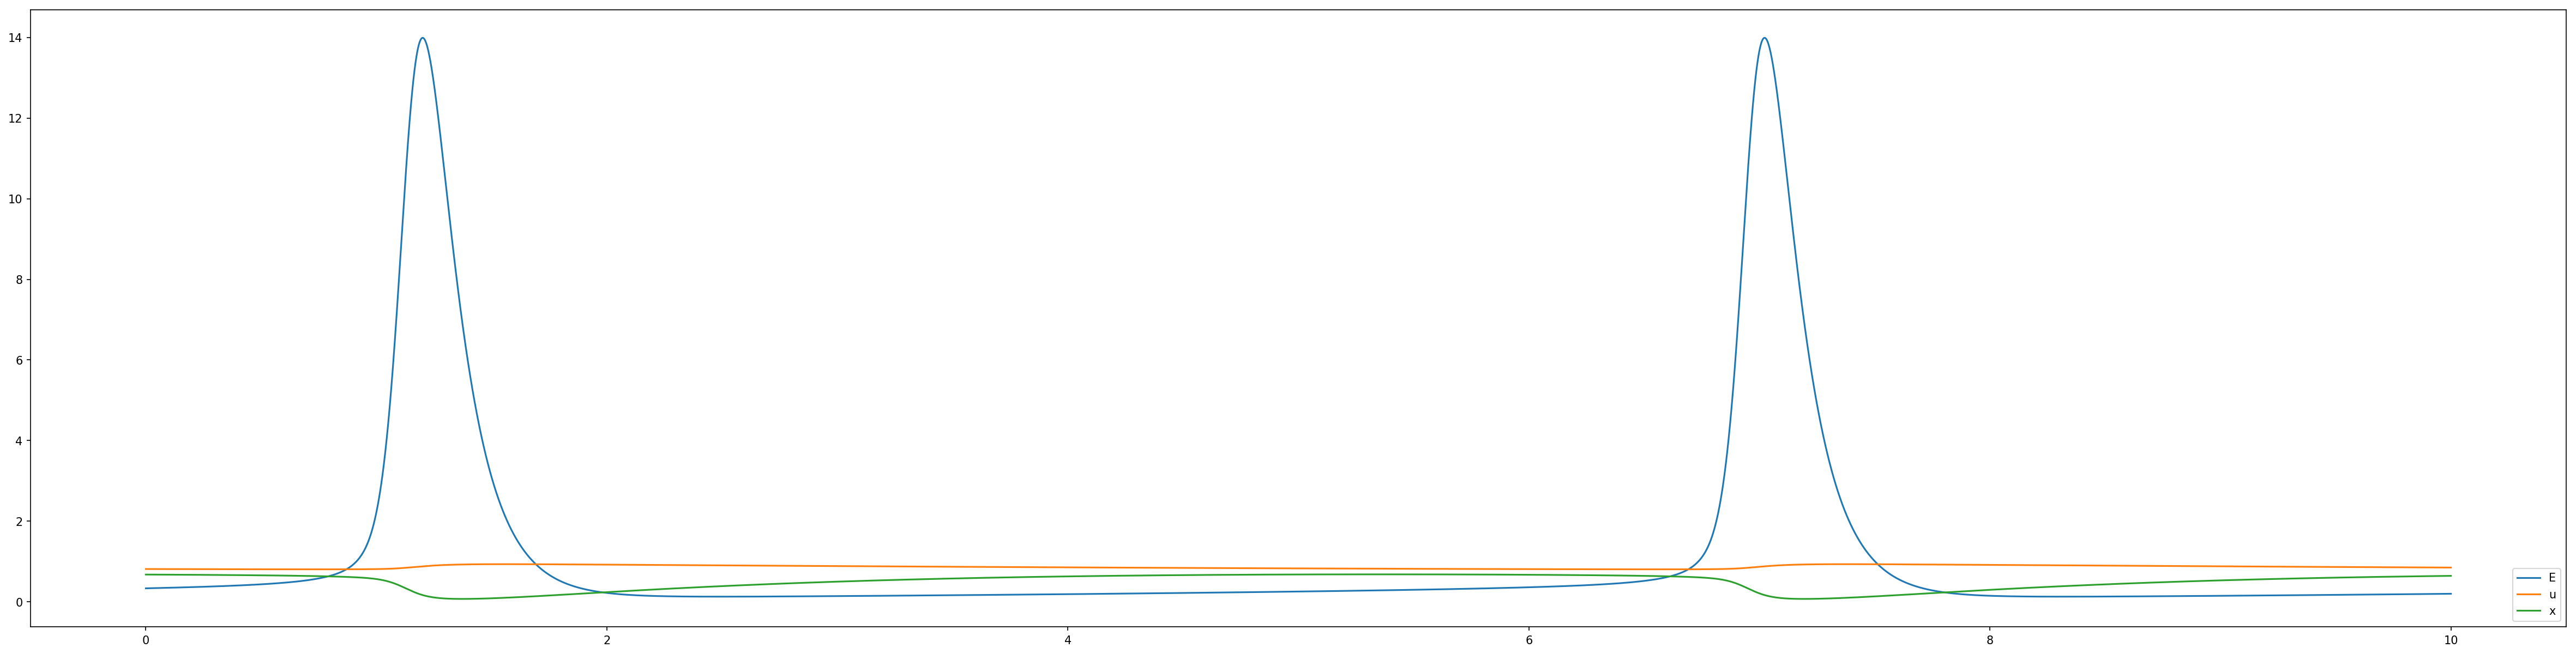

In [153]:
def plot_results(plot_dpi, start_time, end_time):
    plt.clf()
    fig = plt.figure(figsize = (40, 10), dpi = plot_dpi)
    plt.plot(rk_synaptic_neuron.time[int(start_time*(1/dt)):int(end_time*(1/dt))], rk_synaptic_neuron.E_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="E")
    plt.plot(rk_synaptic_neuron.time[int(start_time*(1/dt)):int(end_time*(1/dt))], rk_synaptic_neuron.u_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="u")
    plt.plot(rk_synaptic_neuron.time[int(start_time*(1/dt)):int(end_time*(1/dt))], rk_synaptic_neuron.x_t[int(start_time*(1/dt)):int(end_time*(1/dt))], label="x")
    #plt.plot(time, z_t[:,1], label="threshold")
    plt.legend(loc="lower right")
    plt.show()

plot_results(150, 0, 10)

In [87]:
rk_synaptic_neuron.u_t[0:100]

array([  1.00000000e+00,   5.00000000e-05,   9.99995334e-01,
         1.01997067e-04,   9.99990667e-01,   1.53991187e-04,
         9.99986001e-01,   2.05982361e-04,   9.99981336e-01,
         2.57970589e-04,   9.99976670e-01,   3.09955870e-04,
         9.99972005e-01,   3.61938206e-04,   9.99967341e-01,
         4.13917596e-04,   9.99962676e-01,   4.65894041e-04,
         9.99958012e-01,   5.17867541e-04,   9.99953348e-01,
         5.69838095e-04,   9.99948684e-01,   6.21805704e-04,
         9.99944020e-01,   6.73770369e-04,   9.99939357e-01,
         7.25732089e-04,   9.99934694e-01,   7.77690864e-04,
         9.99930031e-01,   8.29646695e-04,   9.99925369e-01,
         8.81599582e-04,   9.99920707e-01,   9.33549525e-04,
         9.99916045e-01,   9.85496525e-04,   9.99911383e-01,
         1.03744058e-03,   9.99906722e-01,   1.08938169e-03,
         9.99902060e-01,   1.14131986e-03,   9.99897400e-01,
         1.19325509e-03,   9.99892739e-01,   1.24518737e-03,
         9.99888079e-01,